In [65]:
from src.mitnanex import run
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [66]:

clusters_list = run("test/a_gifuensis/a_gifuensis_all_containments.paf")

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in clusters_list.clusters],
        "repr_read_len": [i.longest_read_length for i in clusters_list.clusters],
        "id_longest_read": [i.longest_read_id for i in clusters_list.clusters],
        "id_cluster":[i.id_cluster for i in clusters_list.clusters],
    }
)

In [67]:
# Test on the first 30 clusters
import math
clusters = coverages_df.sort_values(by='coverage', ascending=False)
clusters.sort_values(by='id_longest_read',inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster
59,2,22384,SRR11577123.1234,60
196,2,9265,SRR11577123.1404,197
52,3,22612,SRR11577123.2900,53
5,2,24877,SRR11577123.2979,6
152,2,16105,SRR11577123.3023,153


# Coverage

The first step is to filter the reads by coverage. For that I will explore the use of Kernel Density since this is clusters_list one dimensional clustering.

In [68]:
clusters['transform'] = [math.log2(i)for i in clusters['coverage']]
clusters.sort_values('coverage',ascending=False, inplace=True)
clusters.head()

,coverage,repr_read_len,id_longest_read,id_cluster,transform
55,19,22508,SRR11577129.3284,56,4.247928
30,8,23517,SRR11577123.383,31,3.000000
105,7,19874,SRR11577129.1807,106,2.807355
7,5,24723,SRR11577129.5621,8,2.321928
1,5,24929,SRR11577123.5029,2,2.321928


<Axes: >

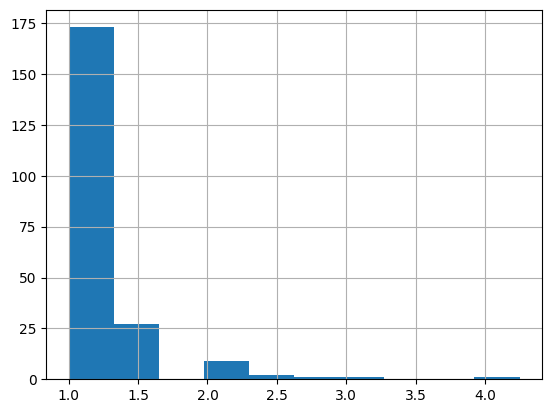

In [69]:
clusters['transform'].hist()

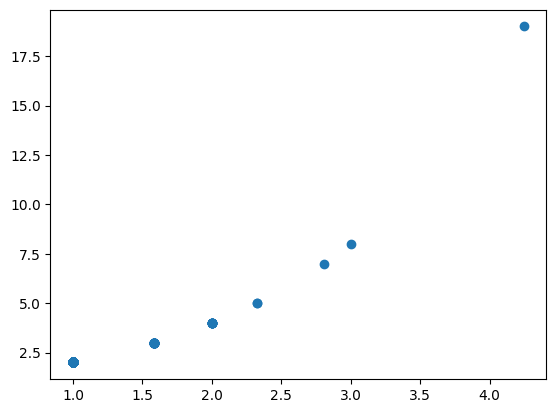

In [70]:
plt.scatter(x=clusters['transform'], y=clusters['coverage'])

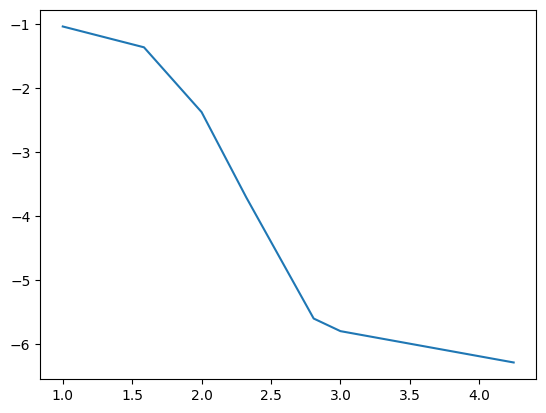

In [71]:
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(clusters['coverage'].array.reshape(-1,1))
cov_fdp = kde.score_samples(clusters['coverage'].array.reshape(-1,1))
plt.plot(clusters['transform'], cov_fdp)

In [72]:
from scipy.signal import argrelextrema
import numpy as np
local_min = argrelextrema(cov_fdp, np.less)[0]
if len(local_min) < 1:
    min_coverage = 1
else:
    min_coverage = clusters.iloc[max(local_min),:]['coverage']
print("Covertura minima admitida: ", min_coverage)

Covertura minima admitida:  1


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create clusters_list script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [73]:
from src.utils import get_sequences_by_id, write_fasta
from src.kmer_cnt import count_kmer

In [75]:
fasta = 'test/a_gifuensis/a_gifuensis_all_sample.sorted.fastq'
repr_reads = [i for i in clusters['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(k=3,seq=seq).values(),ids])

In [76]:
## Get the real mt sequences
with open('test/a_gifuensis/chrMT_reads_ids.txt','r') as handle_ids_mt:
    ids_mt = handle_ids_mt.read().splitlines()
    ids_mt = [i[1:] for i in ids_mt]

In [77]:
hist_df= pd.DataFrame(hist)
hist_df.rename(columns={hist_df.iloc[:,-1].name:'ids'}, inplace=True)
hist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,ids
0,0.147160,0.097385,0.032488,0.033772,0.088922,0.032809,0.036940,0.037903,0.025910,0.015041,...,0.003610,0.009706,0.004492,0.035858,0.013236,0.026993,0.015282,0.006177,0.011190,SRR11577129.1347
1,0.129418,0.091908,0.030329,0.030649,0.086693,0.035464,0.041441,0.034782,0.025153,0.015405,...,0.005977,0.016729,0.006539,0.043126,0.012878,0.026878,0.019216,0.007983,0.017451,SRR11577123.5029
2,0.167757,0.121775,0.029090,0.025639,0.099827,0.027725,0.033303,0.035229,0.022429,0.011194,...,0.003932,0.011074,0.004574,0.035710,0.010593,0.024395,0.012880,0.005015,0.009309,SRR11577124.1047
3,0.128369,0.083223,0.035225,0.034181,0.080492,0.030927,0.032936,0.036832,0.032092,0.015705,...,0.007672,0.014540,0.006908,0.039322,0.015825,0.030365,0.015745,0.011407,0.015745,SRR11577127.605
4,0.138092,0.103689,0.031308,0.028454,0.090869,0.033237,0.037055,0.043124,0.022466,0.014227,...,0.003898,0.010128,0.005184,0.033398,0.014107,0.026324,0.018568,0.006069,0.012258,SRR11577123.6720


# Dimensionality reduction with PCA and clustering with k-means 

In [78]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [79]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-2])

PCA(n_components=2)

In [80]:
## Components and variance explained 
pca.explained_variance_
#pca.components_

array([0.00065652, 0.00018207])

In [81]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-2])
kmer_reduction = pd.DataFrame(kmer_reduction, columns=['comp1', 'comp2'])

## merging the dataframe with ids and other relevant information
kmer_reduction ['ids'] = hist_df['ids']
kmer_reduction = kmer_reduction.merge(clusters, how='left', left_on='ids', right_on='id_longest_read')
kmer_reduction.drop(columns='id_longest_read', inplace=True)

## Annotate which reads are mitochondrial
kmer_reduction['mt'] = (kmer_reduction['ids'].isin(ids_mt).astype(int) + 1) ** 5
kmer_reduction = kmer_reduction[kmer_reduction['coverage'] > min_coverage]
kmer_reduction

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt
0,0.000579,-0.001037,SRR11577129.1347,3,24934,1,1.584963,1
1,-0.022727,0.003853,SRR11577123.5029,5,24929,2,2.321928,1
2,0.040044,0.000633,SRR11577124.1047,4,24925,3,2.000000,1
3,-0.028825,0.007018,SRR11577127.605,2,24899,4,1.000000,1
4,-0.002361,-0.003649,SRR11577123.6720,2,24884,5,1.000000,1
...,...,...,...,...,...,...,...,...
209,0.022921,0.013053,SRR11577124.1459,2,6131,210,1.000000,1
210,-0.002110,-0.002940,SRR11577129.1731,2,5919,211,1.000000,1
211,0.033462,-0.016923,SRR11577125.6819,2,5914,212,1.000000,1
212,0.042950,0.006083,SRR11577129.1821,2,2311,213,1.000000,1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'comp2')

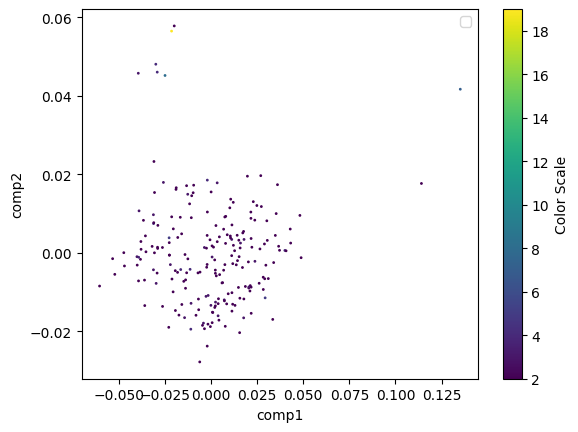

In [82]:
sc = plt.scatter(kmer_reduction['comp1'],kmer_reduction['comp2'], c=kmer_reduction['coverage'], s=kmer_reduction['mt'])
# legend
# Add clusters_list colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()
plt.xlabel('comp1')
plt.ylabel('comp2')

In [83]:
kmeans = KMeans(n_clusters=2, max_iter=100, init='k-means++', random_state=0, n_init=1,verbose=1)
mt_prediction = kmeans.fit_predict(kmer_reduction[['comp1','comp2']])#, sample_weight=kmer_reduction['coverage'])
kmer_reduction['cluster_prediction'] = mt_prediction

Initialization complete
Iteration 0, inertia 0.1700447461973683.
Iteration 1, inertia 0.09607252684975873.
Iteration 2, inertia 0.09488590959326704.
Iteration 3, inertia 0.09472801593907093.
Converged at iteration 3: strict convergence.


Text(0, 0.5, 'comp2')

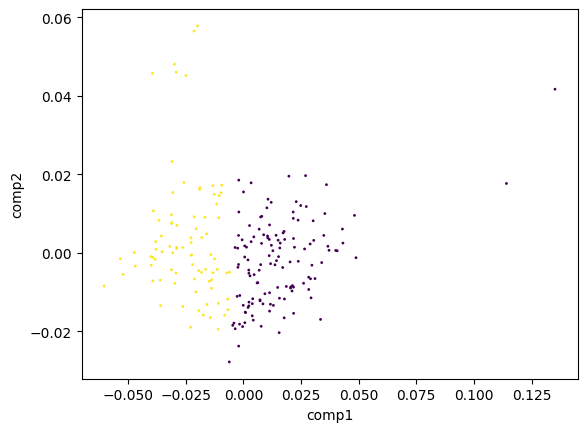

In [84]:
plt.scatter(x=kmer_reduction['comp1'], y=kmer_reduction['comp2'], c=mt_prediction, s=kmer_reduction['mt'])
plt.xlabel('comp1')
plt.ylabel('comp2')

# Get the cluster of interest

This step is clusters_list pain in the ass, but since I am looking to keep the free-reference. 

In [85]:
selected_cluster_id = kmer_reduction.loc[:, kmer_reduction.columns != 'ids'].groupby(by='cluster_prediction')['coverage'].median().idxmax()
selected_cluster = kmer_reduction[kmer_reduction['cluster_prediction'] == selected_cluster_id]
selected_cluster.sort_values('coverage')

,comp1,comp2,ids,coverage,repr_read_len,id_cluster,transform,mt,cluster_prediction
102,0.003366,0.002863,SRR11577123.6347,2,20060,103,1.000000,1,0
148,0.021096,-0.009691,SRR11577128.3727,2,16213,149,1.000000,1,0
147,0.031059,-0.006531,SRR11577125.1179,2,16497,148,1.000000,1,0
144,0.011726,-0.013057,SRR11577123.5356,2,16624,145,1.000000,1,0
141,0.017653,0.005475,SRR11577125.238,2,17014,142,1.000000,1,0
...,...,...,...,...,...,...,...,...,...
60,0.017889,0.003436,SRR11577125.2892,3,22347,61,1.584963,1,0
2,0.040044,0.000633,SRR11577124.1047,4,24925,3,2.000000,1,0
34,-0.002010,0.018540,SRR11577123.7981,4,23312,35,2.000000,1,0
7,0.029344,-0.011435,SRR11577129.5621,5,24723,8,2.321928,1,0


In [86]:
sequences_ids = set()
for i in selected_cluster['id_cluster']:
    sequences_ids.update(clusters_list.get_cluster(i).id_sequences)
write_fasta(fasta=fasta, sequences_ids=sequences_ids, output='test/sara_reads/mt_reads_v1.fasta')

290 reads retrieved
